# Network Graphs

The aim of this notebook is to generate graphs based do two different approaches:

1. **embedding approach**: we use e5-large model to generate embeddings of size 1024 from plots, calculate similarities and based on similarities generate graphs;
2. **genre approach**: we picked genres and themes and let bart-large model to predict the probabilities of belonging to a genre/theme and calculate once again similarities.

## Imports

In [1]:
import itertools
import pickle

import pandas as pd
import networkx as nx

from scripts.helpers import get_similarities_from_json

## Prepare the Data

In [2]:
# get the processed df
df = pd.read_csv('../data/processed/preprocessed.csv', index_col=0)
df.set_index('wikipedia_id', inplace=True)
print(df.shape)
df.head(5)

(22394, 9)


,name,release_year,rating,num_votes,plot,freebase_id,languages,countries,genres
wikipedia_id,,,,,,,,,
10109752,Miss Jerry,1894.0,5.3,207,After finding out that her father is suffering...,/m/02q23xk,['Silent film'],['United States of America'],"['Short Film', 'Silent film', 'Indie', 'Black-..."
28703057,The Corbett-Fitzsimmons Fight,1897.0,5.3,484,The film no longer exists in its entirety; how...,/m/0czdh_n,[],[],['Sports']
142995,The Story of the Kelly Gang,1906.0,6.0,855,The Story of the Kelly Gangs tone is of sorrow...,/m/0120y4,['English Language'],['Australia'],"['Crime Fiction', 'Silent film', 'Biography', ..."
32986669,Robbery Under Arms,1907.0,4.3,25,Key scenes of the film included the branding o...,/m/04p7yxx,['Silent film'],['Australia'],"['Silent film', 'Drama']"
32987200,"Captain Midnight, the Bush King",1911.0,5.4,18,Edgar Dalimore is the son of wealthy station o...,/m/0h569x9,['Silent film'],[],['Silent film']


## Embedding Approach

In [3]:
DECADE = 1920  # the decade we're interested in

# get the similarities as dict and extract list of unique movies
similarity_dict = get_similarities_from_json(DECADE)
movies = list(set(itertools.chain(*similarity_dict.keys())))

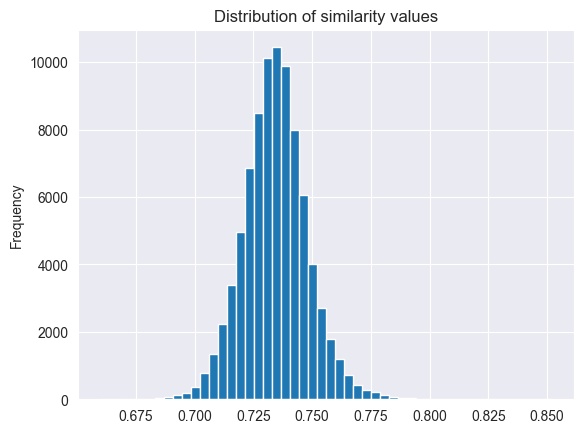

In [4]:
# check the distribution of similarity values
similarity_values = list(similarity_dict.values())
_ = pd.Series(similarity_values).plot.hist(bins=50, title='Distribution of similarity values')

In [5]:
# show descriptive statistics
descriptive_stats = pd.Series(similarity_values).describe()
descriptive_stats

count    85078.000000
mean         0.734374
std          0.013782
min          0.659927
25%          0.725649
50%          0.734179
75%          0.742603
max          0.851925
dtype: float64

75th percentile of the similarities will be used as the threshold for creating an edge between the nodes.

In [6]:
similarity_threshold = descriptive_stats['75%'] 

# generate nodes df and add all the pairs with similarity
similarity_mat = [[key[0], key[1], value] for key, value in similarity_dict.items()]
nodes_df = pd.DataFrame(similarity_mat, columns=['Source', 'Target', 'Weight']) 

# filter based on 75th percentile
nodes_df = nodes_df[nodes_df.Weight > similarity_threshold]

G = nx.from_pandas_edgelist(nodes_df, 'Source', 'Target', 'Weight')

In [7]:
G.number_of_nodes(), G.number_of_edges()

(407, 21270)

For the analysis, we need betweenness and degree, plus few other attributes will be added to the graph.

In [8]:
# add name as an attribute
names = dict((id_, df.loc[int(id_)]['name']) for id_ in G.nodes)
nx.set_node_attributes(G, name='name', values=names)

In [9]:
# add wikipedia id as an attribute
names = dict((id_, int(id_)) for id_ in G.nodes)
nx.set_node_attributes(G, name='wikipedia_id', values=names)

In [10]:
# calculate the betweenness centrality
betweenness = nx.betweenness_centrality(G)
nx.set_node_attributes(G, name='betweenness', values=betweenness)

In [11]:
# calculate degree for each node
degrees = dict(nx.degree(G))
nx.set_node_attributes(G, name='degree', values=degrees)

In [12]:
# add movie rating
ratings_dict = dict((id_, df.loc[int(id_)]['rating']) for id_ in G.nodes)
nx.set_node_attributes(G, name='rating', values=ratings_dict)

In [13]:
# add release year
date_dict = dict((id_, df.loc[int(id_)]['release_year']) for id_ in G.nodes)
nx.set_node_attributes(G, name="release_year", values=date_dict)

Save the graph with all the necessary attributes to pickle

In [14]:
with open(f'../data/embeddings/graphs/{DECADE}s.gpickle', 'wb') as f:
    pickle.dump(G, f, pickle.HIGHEST_PROTOCOL)

## Genre Approach